In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
sns.set_style("darkgrid")

In [2]:
print("Reading data into dataframe...")
df = pd.read_csv("working_xs_v2.csv")
print("Data read into dataframe!")


str_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Origin", "Refer", "Out", "Reaction_Notation", "Title", "Element"]
df[str_cols] = df[str_cols].astype(str)

for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)
        
df[["Protons", "Neutrons", "Mass_Number"]] = df[["Protons", "Neutrons", "Mass_Number"]].astype(int)

Reading data into dataframe...
Data read into dataframe!


# Eliminating Non-Numeric and Non-Categorical Features for ML

In [3]:
columns_drop = ["Refer", "Out", "Reaction_Notation", "Title", "Element"]
df = df.drop(columns=columns_drop)

# One-Hot-Encode Categorical Data (Pandas Dummies)

In [4]:
cat_cols = ["Target_Meta_State", "MT", "I78", "Product_Meta_State", "Frame", "Origin"]

dummy_variables = pd.get_dummies(df[cat_cols])
df = pd.concat([df, dummy_variables], axis=1)
df = df.drop(columns=cat_cols)

# Sample Data for Metrics 

In [5]:
to_plot = df[(df["Protons"] == 17) & (df["MT_103"] == 1) & (df["Mass_Number"] == 35)]
to_plot = to_plot.sort_values(by='Energy', ascending=True)

to_plot2 = df[(df["Protons"] == 17) & (df["MT_102"] == 1) & (df["Mass_Number"] == 35)]
to_plot2 = to_plot2.sort_values(by='Energy', ascending=True)

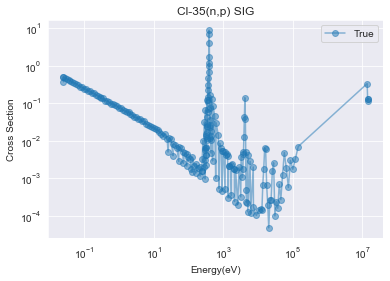

In [24]:
# plt.figure(figsize=(18,10))
plt.plot(to_plot["Energy"], to_plot["Data"], alpha=0.5, label="True", marker="o")
plt.title('Cl-35(n,p) SIG')
plt.xlabel('Energy(eV)')
plt.ylabel('Cross Section')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

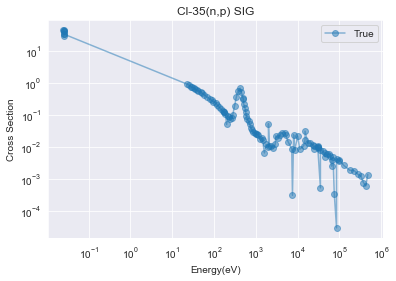

In [25]:
# plt.figure(figsize=(18,10))
plt.plot(to_plot2["Energy"], to_plot2["Data"], alpha=0.5, label="True", marker='o')
plt.title('Cl-35(n,p) SIG')
plt.xlabel('Energy(eV)')
plt.ylabel('Cross Section')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Evaluating Predictions

<p>Two very important measures that are often used in Statistics to determine the accuracy of a model are:</p>
<ul>
    <li><b>R^2 / R-squared</b></li>
    <li><b>Mean Squared Error (MSE)</b></li>
</ul>
    
<b>R-squared</b>

<p>R squared, also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line.</p>
    
<p>The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.</p>



<b>Mean Squared Error (MSE)</b>

<p>The Mean Squared Error measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).</p>

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop(["Data", "dData"], axis=1)
y = df["Data"]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards the larger ones.

In [12]:
from sklearn import preprocessing

In [13]:
to_scale = list(x_train.columns)[:68]

In [14]:
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])

In [15]:
e_scaler = preprocessing.StandardScaler().fit(x_train[["Energy"]])

In [16]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_val[to_scale] = scaler.transform(x_val[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Prediction Function

In [17]:
def predicting_nuclear_xs(MT, Z, M, clf, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # Extracting dataframe to make predictions
    # Copying dataframe to apply model metrics 
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Mass_Number"] == M)]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping Data (XS) for inference    
    # Creating additional points to plot based on energy range given
    # energy_range = np.linspace((1E6*E_min), (E_max*1E6), 200)
    energy_range = np.linspace((1E6*E_min), (E_max*1E6), 200)
    to_infer = to_infer.drop(columns=["Data", "dData"])
    to_infer2 = pd.DataFrame({"Energy": energy_range})
    for i in list(to_infer.columns)[1:]:
        to_infer2[i] = to_infer[i].values[1]
    to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.transform(to_plot[to_scale])
        
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat2 = clf.predict(to_plot.drop(columns=["Data", "dData"]))
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
    to_plot[to_scale] = scaler.inverse_transform(to_plot[to_scale])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(12,10))
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    plt.ylim(1E-5, 1.5E1)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Cross Section Inference ' + MT)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    plt.legend((pred, true), ('Predicted', 'True'), loc='upper left')
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat2))

In [18]:
def predicting_nuclear_xs_e(MT, Z, M, clf, E_min=0.01, E_max=475000):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, M) and runs.
    MT is the reaction type (e.g 1 is total cross section)
    E_min and E_max are the energy region in which to make additional inferences.
    '''
    # --- Extracting dataframe to make predictions and
    #     Copying dataframe to apply model metrics 
    to_infer = df[(df["Protons"] == Z) & (df[MT] == 1) & (df["Mass_Number"] == M)][["Energy", "Data"]]
    to_plot = to_infer.copy().sort_values(by='Energy', ascending=True)
    
    # Dropping Data (XS) for inference
    # Creating additional points to plot based on energy range given
    energy_range = np.linspace((1E6*E_min), (E_max*1E6), 200)
    to_infer = to_infer.drop(columns=["Data"]).append(pd.DataFrame({"Energy": energy_range}), ignore_index=True).sort_values(by='Energy', ascending=True)

    # Applying standard scaler method 
    to_infer["Energy"] = e_scaler.transform(to_infer[["Energy"]])
    to_plot["Energy"] = e_scaler.transform(to_plot[["Energy"]])
        
    # Making Prediction with given model
    y_hat  = clf.predict(to_infer)
    y_hat_2 = clf.predict(to_plot.drop(columns=["Data"]))
    
    # Returning features to original values for plotting
    to_infer[["Energy"]] = e_scaler.inverse_transform(to_infer[["Energy"]])
    to_plot[["Energy"]] = e_scaler.inverse_transform(to_plot[["Energy"]])

    # Initializing Figure and Plotting 
    plt.figure(figsize=(12,10))
    pred = plt.scatter(to_infer["Energy"], y_hat, alpha=0.5)
    true = plt.scatter(to_plot["Energy"], to_plot["Data"], alpha=0.3)
    plt.ylim(1E-5, 1.5E1)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Cl-35 Cross Section ' + MT)
    plt.xlabel('Energy(eV)')
    plt.ylabel('Cross Section (b)')
    plt.legend((pred, true), ('Predicted', 'True'), loc='upper left')
    plt.show()
    
    # Measuring metrics on predictions.
    print("The MSE is: ", mean_squared_error(to_plot["Data"], y_hat_2))
    print("The R2-Score is: ", r2_score(to_plot["Data"], y_hat_2))

# Multi-Variate Linear and Polynomial Regression

These type of models are use mostly to fit a single series of datapoints. This is equivalent to fitting a single experiment/run. One approach to this challenge is to have a series of models for each isotope and for each reaction. Let us try this approach for one isotope and two reactions. We first import the necessary metrics and take a sample of a dataset for Cl-35 (n,g), and (n,p) reactions. This will also serve to test the improvement of our model.

The equation is given by:

$$
Yhat = a + b_1 X_1 + b_2 X_2 + b_3 X_3 + b_4 X_4
$$

<p>We get non-linear relationships by squaring or setting higher-order terms of the predictor variables.</p>

<p>There are different orders of polynomial regression:</p>

<center><b>Quadratic - 2nd order</b></center>
$$
Yhat = a + b_1 X^2 +b_2 X^2 
$$


<center><b>Cubic - 3rd order</b></center>
$$
Yhat = a + b_1 X^2 +b_2 X^2 +b_3 X^3\\
$$


<center><b>Higher order</b>:</center>
$$
Y = a + b_1 X^2 +b_2 X^2 +b_3 X^3 ....\\
$$

It takes one input feature and makes a polynomial of the feature up to X order.

The analytical expression for Multivariate Polynomial function gets complicated. For example, the expression for a second-order (degree=2) polynomial with two variables is given by:

$$
Yhat = a + b_1 X_1 +b_2 X_2 +b_3 X_1 X_2+b_4 X_1^2+b_5 X_2^2
$$

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [20]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Cross Section (b)')
    plt.ylabel('Proportion of Data')

    plt.show()
    plt.close()

In [21]:
# Chlorine for Training and Testing (Single Isotope)
x_cl = to_plot.drop(columns=["Data", "dData"])
x_cl[to_scale] = scaler.transform(x_cl[to_scale])
y_cl = to_plot["Data"]
x_cl_train, x_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.20, random_state=0)

# Only Energy
x_cl_en = x_cl[["Energy"]]

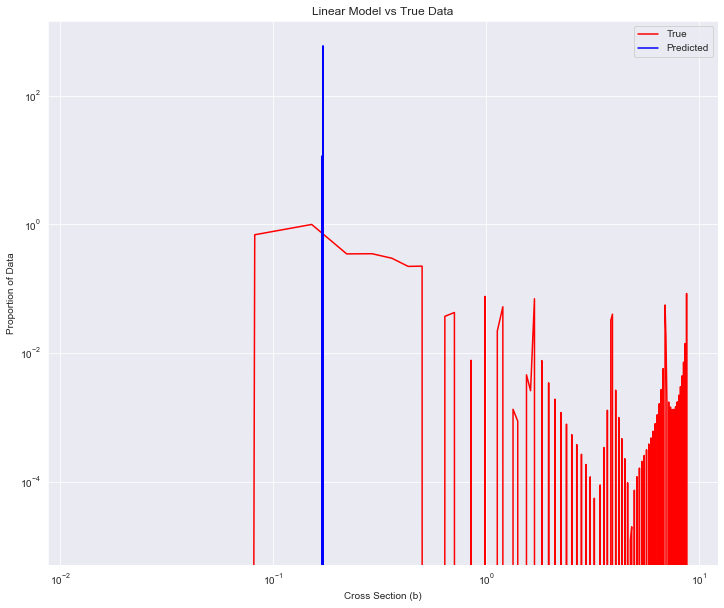

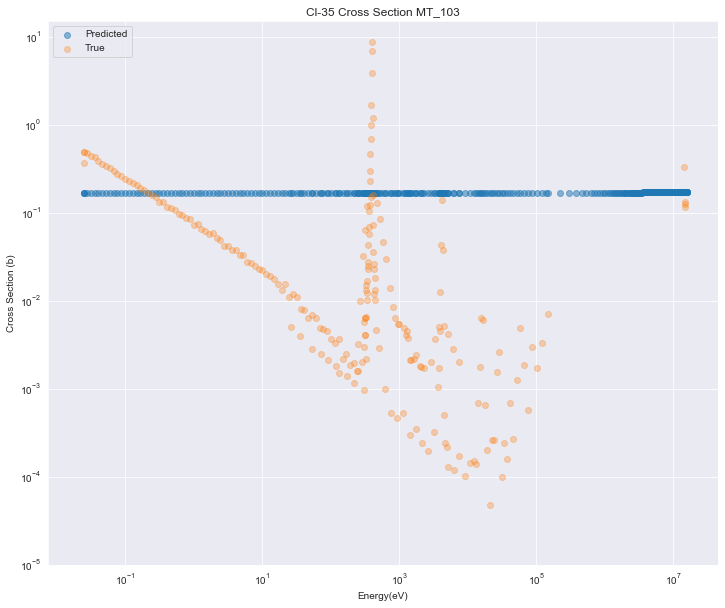

The MSE is:  0.6568534030907327
The R2-Score is:  1.5359601668318845e-07


In [22]:
lm = LinearRegression()
lm.fit(x_cl_en, y_cl)
y_hat = lm.predict(x_cl_en)

DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs_e("MT_103", 17, 35, lm, E_min=0.14, E_max=16)

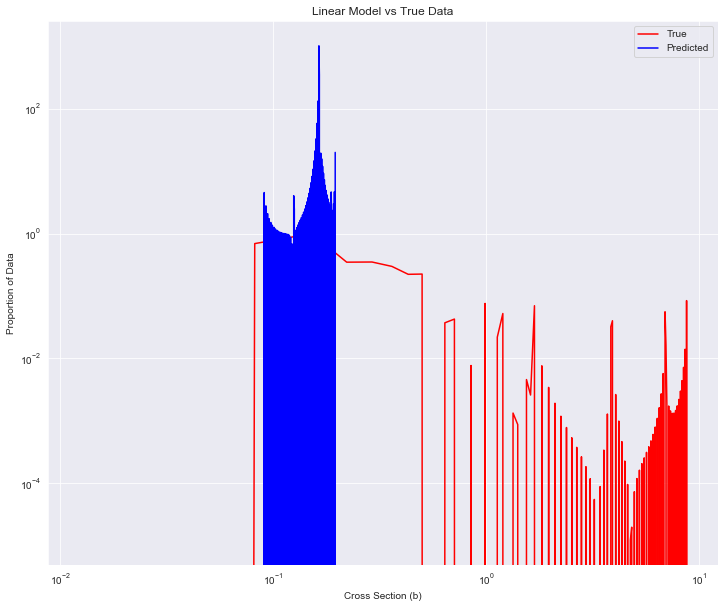

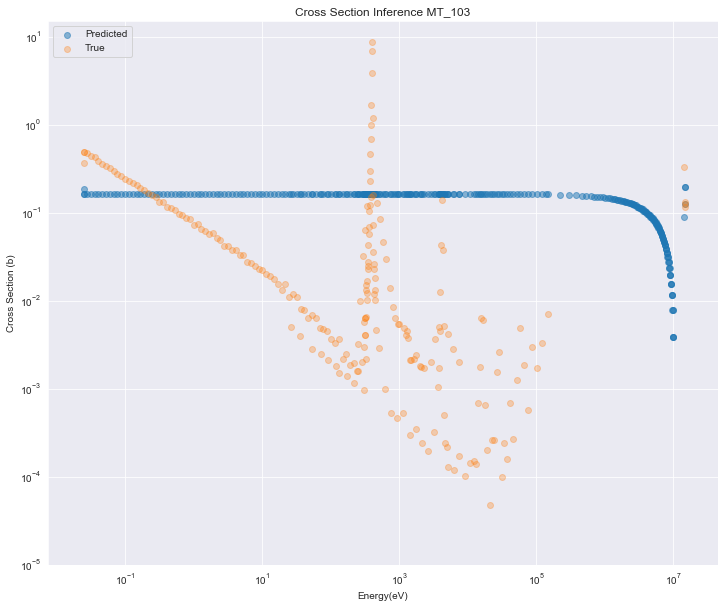

The MSE is:  0.6570005721804227
The R2-Score is:  -0.0002238980209696706


In [23]:
lm = LinearRegression()
lm.fit(x_cl, y_cl)
y_hat = lm.predict(x_cl)

DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, lm, E_min=0.14, E_max=16)

Very slight improvements using other features (so something else might be helping make a better prediction).

### Making Pipelines

Data Pipelines simplify the steps of processing the data. We use the module Pipeline to create a pipeline. We also use StandardScaler as a step in our pipeline.

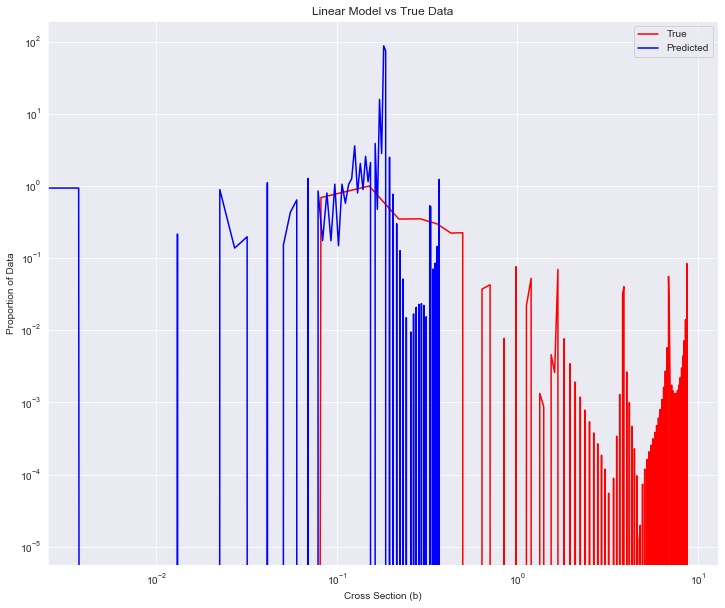

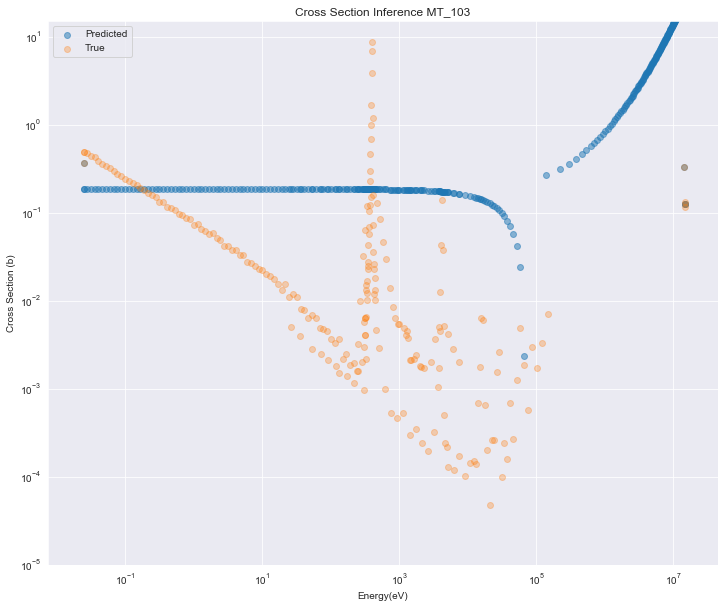

The MSE is:  0.653868532692152
The R2-Score is:  0.0045443485808817075


In [26]:
Input = [('polynomial', PolynomialFeatures(include_bias=False, degree=2)), ('model', LinearRegression(n_jobs=-1))]
pipe = Pipeline(Input)
pipe.fit(x_cl, y_cl)
ypipe = pipe.predict(x_cl)

DistributionPlot(y_cl, ypipe, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, pipe, E_min=0.14, E_max=16)

We got a worse model taking the polynomial of our futures.

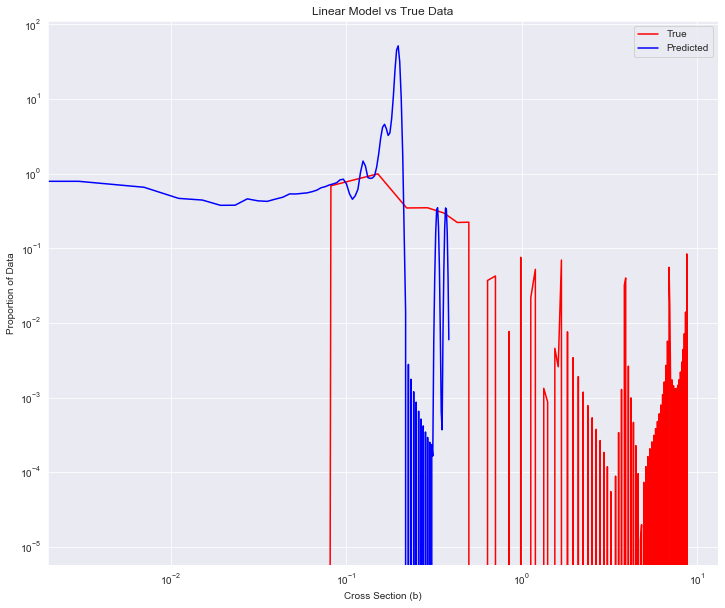

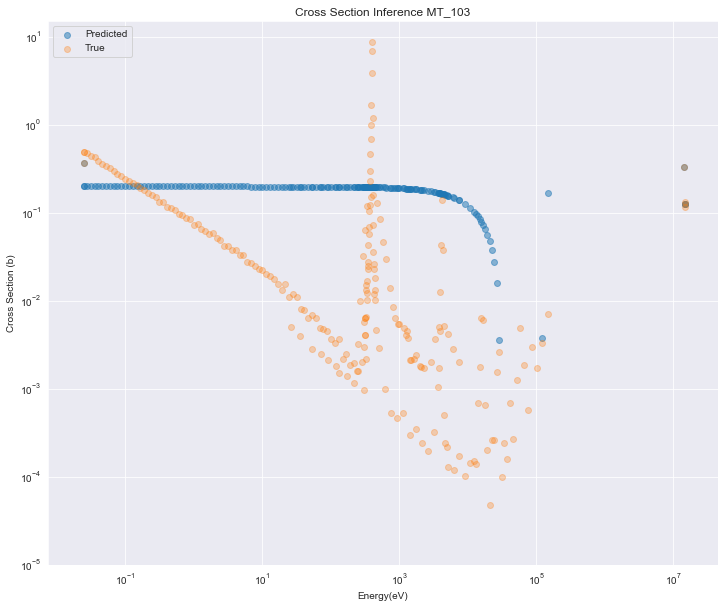

The MSE is:  0.6520177173944999
The R2-Score is:  0.007362047331722521


In [27]:
Input = [('polynomial', PolynomialFeatures(include_bias=False, degree=3)), ('model', LinearRegression(n_jobs=-1))]
pipe = Pipeline(Input)
pipe.fit(x_cl, y_cl)
ypipe = pipe.predict(x_cl)

DistributionPlot(y_cl, ypipe, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, pipe, E_min=0.14, E_max=16)

Much much worse model. Predictively, if we use only energy we can make a high enough order polynomial to overfit the problem. Lets try for the sake of experimentation.

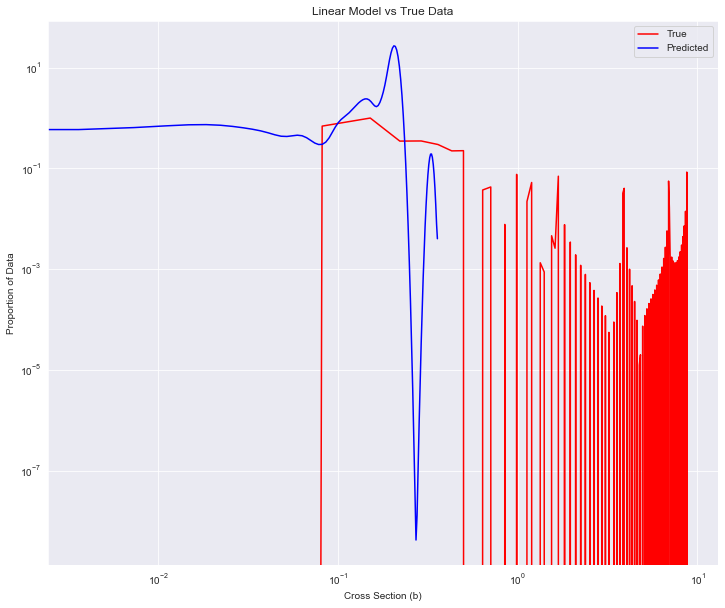

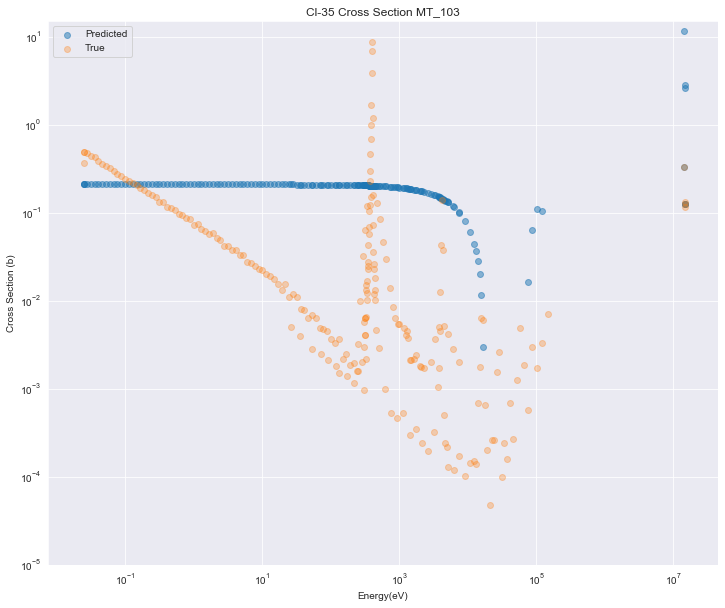

The MSE is:  0.6509170024356288
The R2-Score is:  0.009037786217486632


In [28]:
Input = [('polynomial', PolynomialFeatures(include_bias=False, degree=30)), ('model', LinearRegression(n_jobs=-1))]
pipe = Pipeline(Input)
pipe.fit(x_cl_en, y_cl)
ypipe = pipe.predict(x_cl_en)

DistributionPlot(y_cl, ypipe, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs_e("MT_103", 17, 35, pipe, E_min=0.14, E_max=16)

We can see a much better model than any of the previous ones. We can see how the model is trying to overfit to the problem but it is struggling. 

# Cross Validation Score

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [30]:
lre = LinearRegression()
Rcross = cross_val_score(lre, x_cl_en, y_cl, cv=4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())
-1 * cross_val_score(lre, x_cl_en, y_cl, cv=4, scoring='neg_mean_squared_error')

The mean of the folds are -1515807.942648292 and the standard deviation is 2625377.683215901


array([2.03135685e-02, 4.54994101e-02, 2.63788837e+00, 1.79405083e+04])

In [31]:
yhat = cross_val_predict(lre, x_cl_en, y_cl, cv=4)

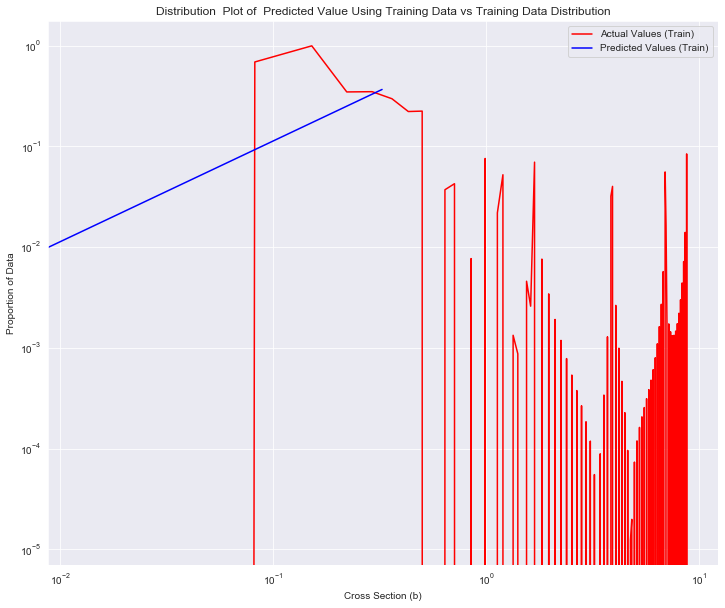

In [32]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_cl, yhat, "Actual Values (Train)", "Predicted Values (Train)", Title)

# Ridge Regression

In [33]:
from sklearn.linear_model import Ridge

# Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
RR=Ridge()
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
Grid1 = GridSearchCV(RR, parameters1, cv=4)
Grid1.fit(x_cl, y_cl)
BestRR = Grid1.best_estimator_
BestRR.score(x_cl, y_cl)
# BestRR.score(x_cl, y_test)

0.00028563666204117766

In [36]:
parameters2 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000], "normalize":[True, False]}]
Grid2 = GridSearchCV(Ridge(), parameters2, cv=4, return_train_score=False)
Grid2.fit(x_cl, y_cl)
BestRR2 = Grid2.best_estimator_
BestRR2.score(x_cl, y_cl)
# BestRR.score(x_cl, y_test)

0.00028563666204117766

In [37]:
yhat = BestRR2.predict(x_cl)

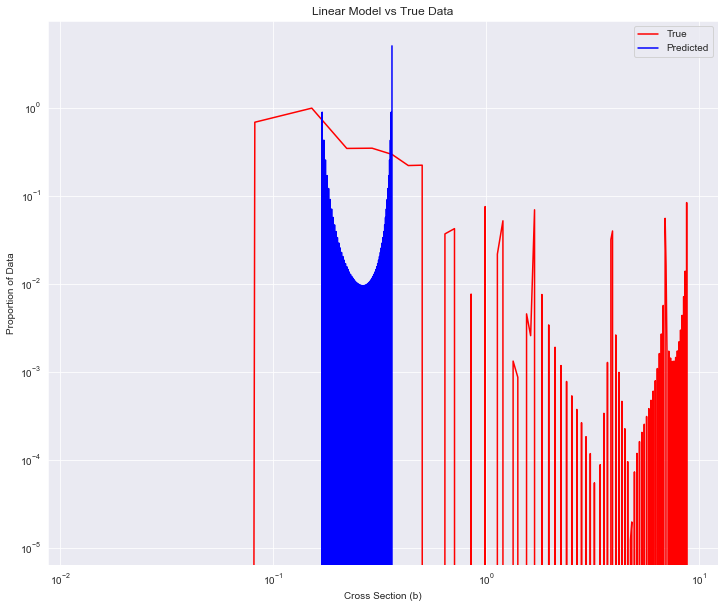

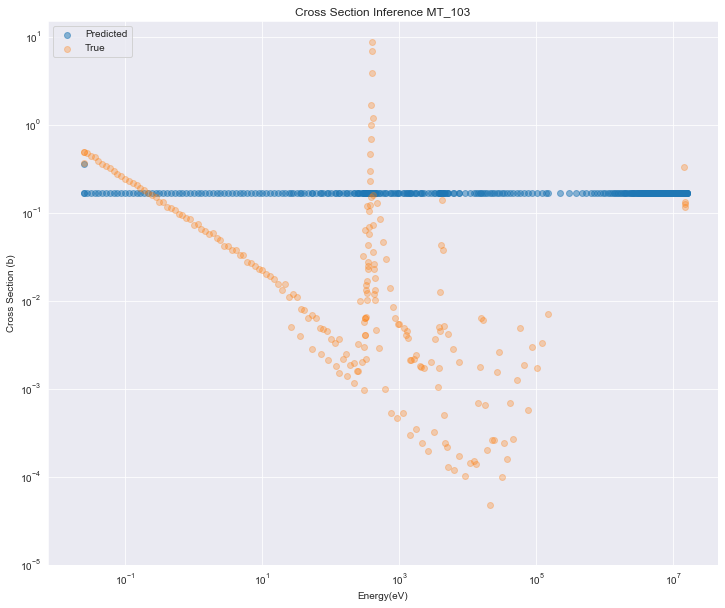

The MSE is:  0.6566658825384872
The R2-Score is:  0.00028563666204117766


In [38]:
DistributionPlot(y_cl, yhat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("MT_103", 17, 35, BestRR2, E_min=0.14, E_max=16)

In [39]:
pd.DataFrame(Grid2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003751,8.292401e-04,0.001250,4.331190e-04,0.001,True,"{'alpha': 0.001, 'normalize': True}",-0.012587,-134.934274,-0.075428,-8.259301e+06,-2.064859e+06,3.576363e+06,18
1,0.003501,5.002024e-04,0.001250,4.331879e-04,0.001,False,"{'alpha': 0.001, 'normalize': False}",-0.009952,-135.065350,-0.075356,-1.340645e+01,-3.713928e+01,5.680027e+01,12
2,0.003501,5.004407e-04,0.001000,1.685874e-07,0.1,True,"{'alpha': 0.1, 'normalize': True}",-0.012828,-135.061267,-0.075299,-7.497702e+06,-1.874459e+06,3.246581e+06,17
3,0.003251,4.328437e-04,0.001000,3.097148e-07,0.1,False,"{'alpha': 0.1, 'normalize': False}",-0.009947,-134.184578,-0.074802,-1.341033e+01,-3.691991e+01,5.642035e+01,4
4,0.003001,5.685921e-07,0.001000,7.072241e-04,1,True,"{'alpha': 1, 'normalize': True}",-0.012728,-134.582959,-0.075000,-3.671706e+06,-9.179602e+05,1.589876e+06,16
5,0.003501,4.999638e-04,0.000750,4.331190e-04,1,False,"{'alpha': 1, 'normalize': False}",-0.009826,-133.478848,-0.074448,-1.341092e+01,-3.674351e+01,5.611622e+01,2
6,0.003001,2.384186e-07,0.001000,1.685874e-07,10,True,"{'alpha': 10, 'normalize': True}",-0.012048,-133.810865,-0.074437,-2.311439e+05,-5.781944e+04,1.000689e+05,15
7,0.003001,3.097148e-07,0.001000,3.576279e-07,10,False,"{'alpha': 10, 'normalize': False}",-0.009804,-133.399647,-0.074357,-1.341629e+01,-3.672503e+01,5.608154e+01,1
8,0.003001,2.598106e-07,0.001000,2.064765e-07,100,True,"{'alpha': 100, 'normalize': True}",-0.010544,-134.110024,-0.073976,-3.314619e+03,-8.622035e+02,1.416960e+03,14
9,0.003001,3.576279e-07,0.000750,4.329815e-04,100,False,"{'alpha': 100, 'normalize': False}",-0.009802,-133.718814,-0.074161,-1.345232e+01,-3.681377e+01,5.621538e+01,3
